## Faster RCNN

The following dataset represents the fine-tuning of the Faster R-CNN model version 2 on the PITA dataset for watermark detection.

In [1]:
!pip install -qqq -U datasets
!pip install -qqq torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -qqq -U lightning
!pip install -qqq pycocotools faster-coco-eval

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.3.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.1.4 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2024.1.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2024.1.0 which is incompatible.
dask-cuda 23.8.0 require

In [2]:
!pip install -qqq wandb
import wandb

In [3]:
wandb.login(key="ec4686ac5050e0bf8bc0ab89232ded2ceed28121")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import os

import pytorch_lightning as pl
import torch
from datasets import load_dataset
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.utilities.types import EVAL_DATALOADERS
from torch.utils.data import DataLoader, Dataset
from torchmetrics.detection import MeanAveragePrecision
from torchvision.models.detection import (
    faster_rcnn,
    FasterRCNN_ResNet50_FPN_V2_Weights,
    fasterrcnn_resnet50_fpn_v2,
)
from torchvision.ops import box_convert
from torchvision.transforms import functional as F
from torchvision import transforms
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

## Using a Custom Dataset

The dataset that will be used is the PITA dataset for visible watermark object detection. The preprocessing involves resizing the images to 224x224 pixels and normalizing them.

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class CustomDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item["image"]
        image = transform(image)

        target = {}
        ratio = 224 / 512
        target["boxes"] = torch.tensor([item["bbox"]]) * ratio

        target["boxes"] = box_convert(target["boxes"], in_fmt="cxcywh", out_fmt="xyxy")
        target["boxes"] /= 1
        target["labels"] = torch.tensor([item["category_id"]])

        return image, target

    def __len__(self):
        return len(self.hf_dataset)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_boxes(image, target, prediction=None, bbox_scale=224):
    """
    Show an image with its ground truth bounding boxes and optionally prediction boxes.
    Args:
        image (Tensor): The image tensor.
        target (dict): The target dictionary containing 'boxes' and 'labels'.
        prediction (dict): Optional. The prediction dictionary containing 'boxes' and 'labels'.
        bbox_scale (float): The scale factor for the bounding boxes.
    """
    fig, ax = plt.subplots(1)
    # Move image to CPU and convert to numpy, assuming image is [C, H, W]
    ax.imshow(image.cpu().permute(1, 2, 0).numpy())

    for box in target['boxes'].cpu().numpy():
        scaled_box = box * bbox_scale
        rect = patches.Rectangle(
            (scaled_box[0], scaled_box[1]), scaled_box[2] - scaled_box[0], scaled_box[3] - scaled_box[1],
            linewidth=2, edgecolor='g', facecolor='none'
        )
        ax.add_patch(rect)

    if prediction is not None:
        for box in prediction['boxes'].cpu().numpy():
            scaled_box = box * bbox_scale
            rect = patches.Rectangle(
                (scaled_box[0], scaled_box[1]), scaled_box[2] - scaled_box[0], scaled_box[3] - scaled_box[1],
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

    plt.show()

Then, we can define the LightningModule for Faster R-CNN and load the pretrained version 2 of the model. We are going to fine-tune only the input features of the ROI (Region of Interest) heads.

In [7]:
class FasterRCNNModule(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()

        self.model = fasterrcnn_resnet50_fpn_v2(
            weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
            pretrained=True,
        )

        in_features = self.model.roi_heads.box_predictor.cls_score.in_features

        self.model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(
            in_features, num_classes
        )

    def forward(self, images, targets=None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self(images, targets)

        # Combining the localization and classification losses
        loss = sum(loss for loss in loss_dict.values())

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        model.train()

        # BatchNorm are already frozen and we want to get the loss on the validation set
        with torch.no_grad():
            images, targets = batch
            loss_dict = self(images, targets)

            loss = sum(loss for loss in loss_dict.values())
            self.log("val_loss", loss)
            self.log("val_train_loss_classifier", loss_dict["loss_classifier"])
            self.log("val_train_loss_rpn_box_reg", loss_dict["loss_rpn_box_reg"])
            self.log("val_train_loss_box_reg", loss_dict["loss_box_reg"])
            self.log("val_train_loss_objectness", loss_dict["loss_objectness"])

        return loss

    def test_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images)
        metric = MeanAveragePrecision(
            iou_type="bbox", box_format="xyxy", class_metrics=True
        )
        metric.update(preds, targets)

        result = metric.compute()

        self.log("map", result["map"].item())
        self.log("map_50", result["map_50"].item())
        self.log("map_75", result["map_75"].item())
        if result["map_per_class"].ndimension() > 0 and result["map_per_class"].size(0) > 1:
            self.log("map_per_class_0", result["map_per_class"][0].item())
            self.log("map_per_class_1", result["map_per_class"][1].item())

        return metric

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return super().test_dataloader()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [8]:
BATCH_SIZE = 8

CPU_COUNT: int = os.cpu_count() or 0

In [9]:
def load_split(
    split: str, shuffle: bool
) -> DataLoader:
    hf_dataset = load_dataset("bastienp/visible-watermark-pita", split=split)
    dataset = CustomDataset(hf_dataset, transform=transform)

    data_loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=CPU_COUNT,
    )

    return data_loader

In [10]:
train_dataloader = load_split("train", shuffle=True)
val_dataloader = load_split("val", shuffle=False)
test_dataloader = load_split("test", shuffle=False)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

## Plot sample

We are going to verify that the dataset was correctly processed, ensuring that the images were properly preprocessed and that the bounding boxes were accurately resized.

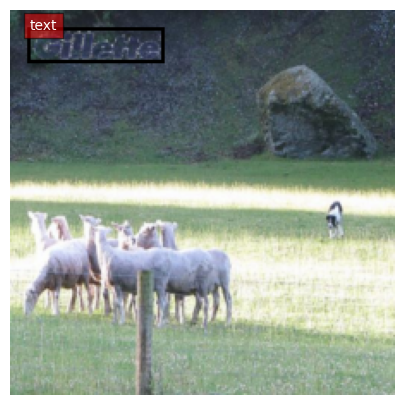

In [11]:
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image, to_tensor
import numpy as np
import matplotlib.pyplot as plt

def visualize_batch_sample(dataloader, batch_idx, image_idx, class_names=None):

    for i, (images, targets) in enumerate(dataloader):
        if i == batch_idx:
            image = images[image_idx]
            target = targets[image_idx]
            break


    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = to_pil_image(image * std[:, None, None] + mean[:, None, None])

    boxes = target['boxes']
    labels = target['labels']
    drawn_boxes = draw_bounding_boxes(to_tensor(image).mul(255).byte(), boxes, width=2)
    image_with_boxes = to_pil_image(drawn_boxes)

    plt.figure(figsize=(5, 5))
    plt.imshow(image_with_boxes)
    plt.axis('off')

    if class_names:
        for i, box in enumerate(boxes):
            plt.text(
                box[0], box[1],
                f'{class_names[labels[i].item() - 1]}',
                color='white',
                bbox=dict(facecolor='red', alpha=0.5)
            )

    plt.show()


visualize_batch_sample(train_dataloader, batch_idx=0, image_idx=0, class_names=['logo','text'])

Now we are able to train our model and test it on the PITA dataset using the Lightning Trainer.

In [13]:
NUM_CLASSES = 3
model = FasterRCNNModule(num_classes=NUM_CLASSES)

wandb_logger = WandbLogger(project="faster-rcnn-pita-dataset", log_model="all")

directory = "checkpoints"
os.makedirs("checkpoints", exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='pita-faster-rcnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)


trainer = pl.Trainer(
    devices="auto",
    max_epochs=5,
    accumulate_grad_batches=BATCH_SIZE,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

# trainer.save_checkpoint("faster-rcnn-pita.ckpt")

trainer.test(model, dataloaders=test_dataloader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            map            │    0.36666300892829895    │
│          map_50           │     0.645662784576416     │
│          map_75           │    0.38531914353370667    │
│      map_per_class_0      │    0.2838734984397888     │
│      map_per_class_1      │    0.35238489508628845    │
└───────────────────────────┴───────────────────────────┘

[{'map': 0.36666300892829895,
  'map_50': 0.645662784576416,
  'map_75': 0.38531914353370667,
  'map_per_class_0': 0.2838734984397888,
  'map_per_class_1': 0.35238489508628845}]